# Assignment: Generative Adversarial Network (GAN) {-}

This assignment aims at familiarizing you with training, validating and testing a Generative Adversarial Network (GAN). Here are the requirements of the assignment:

- Load the dataset. To save training time, you only need to load and work on ONE image class of your choice.
- Process the images.
- Build a GAN architecture consisting of at least one (01) Discriminator and one (01) Generator of which the architectures are of your choice. You are encouraged to customize the network architectures to be different from the ones demonstrated in the demo code. There are two levels of image generation requirements:
    - First-level requirement: train and generate images for ONE class of the dataset using vanilla GAN. You are free to choose which class of object you are interested in working on.
    - Second-level requirement: train and generate images for ONE class of the dataset using the mechanism of ProGAN. In this requirement, you do not need to strictly follow the implementation in the ProGAN paper. Feel free to construct a light version (a simple incremental network architecture) of it yourself.
- Visualize the model behaviors during the training.
- Visualize the generated images.

The dataset you will be working on is CIFAR-10. This dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

Here follows some data samples in the dataset:

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment-DL4CV-notebook.ipynb: Jupyter notebook containing source code, for example 2012345-assignment-DL4CV-notebook.ipynb

### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. It is a plus if you have modeling steps other than the basic requirements and achieve an excellent model performance. In addition, your code should conform to a Python coding convention such as PEP-8.

### Deadline {-}
Please visit Canvas for details.

In [1]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=b773a33193040edbb7cc5cc74486ff4c440df374ca02399defd3c9c757305001
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [2]:
!pip install tensorflow_datasets

# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import np_utils
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import zeros, ones, vstack, expand_dims
from numpy.random import randn, randint

from keras.layers import Layer
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.layers import (Add, AveragePooling2D, Lambda, UpSampling2D, MaxPool2D, Activation,
                          InputLayer, Input, Dropout, Flatten, Dense, BatchNormalization, Conv2D,
                          MaxPooling2D, Conv2DTranspose, LeakyReLU, Reshape, GlobalMaxPooling2D)
from keras.models import Sequential
from keras import Model
from keras.optimizers import Adam, SGD

# A. First-level requirement
First-level requirement: train and generate images for ONE class of the dataset using vanilla GAN. You are free to choose which class of object you are interested in working on.

In [3]:
# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name="cifar10", split=tfds.Split.TRAIN, batch_size=-1 )
cifar10_test = tfds.load(name="cifar10", split=tfds.Split.TEST, batch_size=-1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train)
cifar10_test = tfds.as_numpy(cifar10_test)

# Seperate feature X and label Y
X_train, y_train = cifar10_train["image"], cifar10_train["label"]
X_test, y_test = cifar10_test["image"], cifar10_test["label"]

# Print shapes of the entire training and test set of CIFAR 10
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete82TDHD/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete82TDHD/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (50000,)
y_test shape: (10000,)


In [4]:
# Load CIFAR-10 dataset with information
cifar10_info = tfds.builder("cifar10").info

# Get class names
class_names = cifar10_info.features["label"].names

# Print class names
print("Class Names:", class_names)


Class Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# Get samples  of a certain label
label = 8 # Class '8' is ship.
train_indices = np.where(y_train == label) # Get indices of the label
train_set = X_train[train_indices] # Get train samples of the label
test_indices = np.where(y_test == label) # Get indices of the label
test_set = X_train[test_indices] # Get test samples of the label

# Print shapes of datasets of the selected class
print("train_set shape of the selected class: " + str(train_set.shape))
print("test_set shape of the selected class: " + str(test_set.shape))

# NOTE: training a GAN does not require to have train/test split. All data samples of the training and the test set are used as real data samples.
# You should merge the training and the test set to get more real data samples, i.e., merge the train_set and the test_set to one dataset which is the real dataset.

train_set shape of the selected class: (5000, 32, 32, 3)
test_set shape of the selected class: (1000, 32, 32, 3)


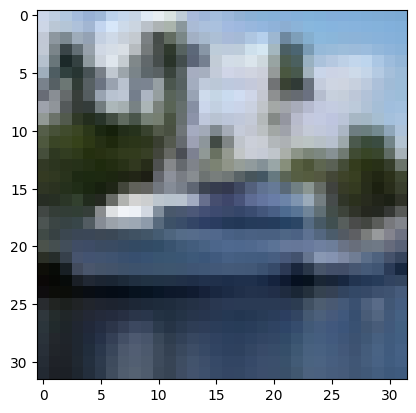

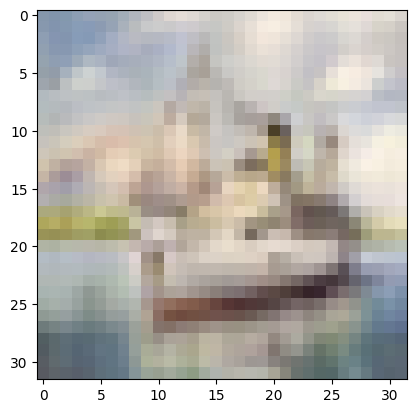

In [6]:
# Visualize some data samples of class '4' (cat)
import matplotlib.pyplot as plt
imgplot = plt.imshow(train_set[0])
plt.show()
imgplot = plt.imshow(train_set[1])
plt.show()

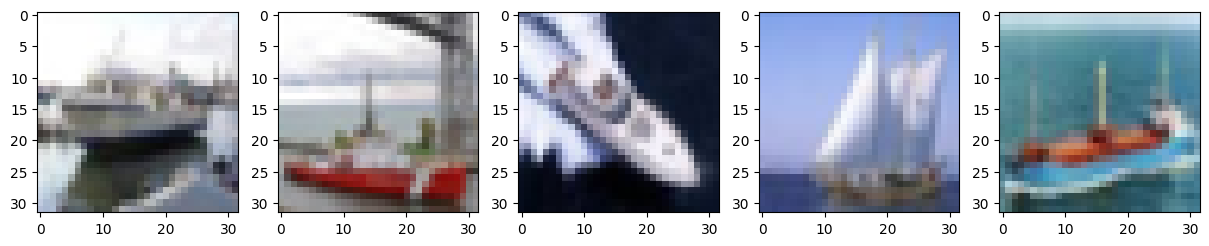

In [7]:
# Display the first 5 images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))  # Adjust figsize as needed
for i in range(5):
    axes[i].imshow(train_set[i+5])
plt.show()


In [8]:
# Your code goes here


## 1) Prepare samples

### 1.1. Prepare real samples

In [9]:
def load_real_samples():
    # merge the train_set and the test_set to the "real dataset"
    X = np.concatenate((train_set, test_set), axis=0)
    # Convert pixel values from unsigned int to float32 for normalization calculation.
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    # Return the set of normalized images
    return X

# Select real samples from the real dataset for training purpose
def generate_real_samples(dataset, n_samples):
    # Generate random n_samples sample indices from the dataset
    ix = randint(0, dataset.shape[0], n_samples)
    # Get the images from the list of indices
    X = dataset[ix]
    # Generate labels for the real samples (label=1)
    y = ones((n_samples, 1))
    return X, y # Return the real images and labels.


### 1.2. Prepare fake samples for Discriminator

In [10]:
# Generate random latent vectors as input for Generator
def generate_latent_points(latent_dim, n_samples):
    # Generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # Reshape to a batch of inputs for the Generator
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Use Generator to generate n_samples fake samples
def generate_fake_samples(g_model, latent_dim, n_samples):
    # Generate random latent vectors as input for Generator
    x_input = generate_latent_points(latent_dim, n_samples)
    # Generate fake data samples by passing the random latent vectors through the Generator
    X = g_model.predict(x_input)
    # Generate labels for the fake samples (label=0)
    y = zeros((n_samples, 1))
    return X, y # Return the fake images and labels.

## 2) Build Generator and Discriminator

### 2.1. Build Generator

In [11]:
# Define the structure of Generator
def define_generator(latent_dim):
    # latent_dim: dimension of the random input vector

    model = Sequential()

    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(input_dim=latent_dim, units=n_nodes))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    # upsample from 4x4x256 to 8x8x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample from 8x8x128 to 16x16x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample from 16x16x128 to 32x32x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Convert from 32x32x128 to 32x32x3 conforming to Discriminator's input
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

    return model # Return the Generator

# Show a sample of Generator structure
generator = define_generator(128)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              528384    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                             

### 2.2 Build the Discriminator

In [12]:
# Define the structure of Discriminator
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # Block 1 conv
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    # Block 2 conv: downsample from 32x32x64 to 16x16x128
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Block 3 conv: downsample from 16x16x128 to 8x8x128
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Block 4 conv: downsample from 8x8x128 to 4x4x256
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model
# Show a sample of Discriminator structure
sample_discriminator = define_discriminator()
sample_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)        

### 2.3. Build the GAN with Generator and Disciminator

In [13]:
# Define the GAN network consisting of a Generator and a Discriminator
def define_gan(g_model, d_model):
    # g_model: Generator component
    # d_model: Discriminator component

    model = Sequential() # Initialize a sequential model
    model.add(g_model) # Add the Generator component
    model.add(d_model) # Add the Discriminator component
    return model # Return the GAN

In [14]:
# Train the Generator and the Discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=201, n_batch=4096):
    bat_per_epo = int(dataset.shape[0] / n_batch) # Number of iterations per epoch
    half_batch = int(n_batch / 2) # A batch to the Discriminator contains real samples (half-batch) and fake samples (half-batch)

    d_loss_values = [] # Array containing Discriminator loss over iterations
    g_loss_values = [] # Array containing Generator loss over iterations

    # Number of epochs
    for i in range(n_epochs):
        # Number of iterations
        for j in range(bat_per_epo):

            # Randomly get half_batch real data samples from the real dataset
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # Generate half_batch fake data samples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Create training set for the discriminator: half-batch real and half-batch fake
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

            # Update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)

            # Generate random latent vectors as input for Generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # Generate inverted labels for the fake samples to train the Generator
            y_gan = ones((n_batch, 1))
            # Train the Generator
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Training log after every iteration
            print('Epoch %d, Iteration %d/%d, D_loss = %.3f, G_loss = %.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

            # Add loss values to historical arrays
            d_loss_values.append(d_loss)
            g_loss_values.append(g_loss)

        # Plot the generated images every certain number of epochs
        if (i+1) % 10 == 0:
            X_fake, _ = generate_fake_samples(g_model, latent_dim, 100) # Generate 100 fake data samples using the Generator. Pixel values are in [0,1]
            save_plot(X_fake, i, n=10) # Plot a grid of 10x10 fake samples and save to file at epoch i

    return d_loss_values, g_loss_values # Return the loss arrays of Generator and Discriminator

In [ ]:
!mkdir generated_1

In [15]:
# Create and save a plot of generated images
def save_plot(samples, epoch, n=10):
    # scale from [-1,1] to [0,1]
    samples = (samples + 1) / 2.0
    # Define a plot of (n rows, n columns)
    for i in range(n * n):
        # (1+i) is the index position on a grid with nrows rows and ncols columns. Index starts at 1 in the upper left corner and increases to the right.
        plt.subplot(n, n, 1+i)
        plt.axis('off') # Disable axis
        plt.imshow(samples[i, :, :, :]) # Plot the sample i with reversed gay color map
    filename = '/content/generated_1/Plot_epoch_%03d.png' % (epoch+1)
    plt.savefig(filename) # Save plot to file
    plt.close() # Close the plot

## 3) Train Model

In [16]:
# Size of the latent space
latent_dim = 128
epochs = 201
batch_size = 128

# Initialize an optimizer. Pick one.
opt_d = Adam(learning_rate=0.0002, beta_1=0.5) # Adam optimizer with customized values for discriminator
opt_g = Adam(learning_rate=0.0002, beta_1=0.5) # Adam optimizer with customized values for generator

# Create the Discriminator
d_model = define_discriminator()
d_model.trainable = True
d_model.compile(loss='binary_crossentropy', optimizer=opt_d, metrics=['accuracy'])

# Create the Generator
g_model = define_generator(latent_dim)

# Create the GAN
d_model.trainable = False
gan_model = define_gan(g_model, d_model)
gan_model.compile(loss='binary_crossentropy', optimizer=opt_g)

# Load real image data from the MNIST dataset
dataset = load_real_samples()

In [17]:
# Train the GAN
d_losses, g_losses = train(g_model, d_model, gan_model, dataset, latent_dim, epochs, batch_size)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
2/2 [==============================] - 0s 4ms/step
Epoch 147, Iteration 34/46, D_loss = 0.680, G_loss = 0.804
2/2 [==============================] - 0s 4ms/step
Epoch 147, Iteration 35/46, D_loss = 0.633, G_loss = 0.852
2/2 [==============================] - 0s 5ms/step
Epoch 147, Iteration 36/46, D_loss = 0.644, G_loss = 0.860
2/2 [==============================] - 0s 4ms/step
Epoch 147, Iteration 37/46, D_loss = 0.662, G_loss = 0.831
2/2 [==============================] - 0s 5ms/step
Epoch 147, Iteration 38/46, D_loss = 0.637, G_loss = 0.835
2/2 [==============================] - 0s 4ms/step
Epoch 147, Iteration 39/46, D_loss = 0.628, G_loss = 0.833
2/2 [==============================] - 0s 4ms/step
Epoch 147, Iteration 40/46, D_loss = 0.597, G_loss = 0.847
2/2 [==============================] - 0s 4ms/step
Epoch 147, Iteration 41/46, D_loss = 0.601, G_loss = 0.916
2/2 [==============================] - 0s 4ms/step
Epoch 147, I

## 4) Visualize the model behaviors during the training

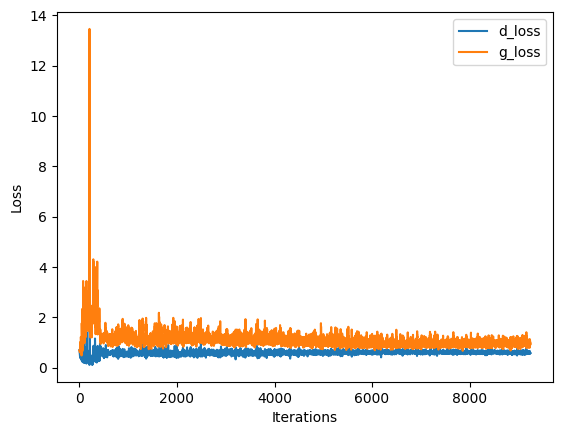

In [18]:
# Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses), len(d_losses))
gx = np.linspace(0,len(g_losses), len(d_losses))

# Plot the training loss of G and D
plt.plot(dx, d_losses)
plt.plot(gx, g_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()


## 5) Visualize the generated images

In [22]:
from PIL import Image

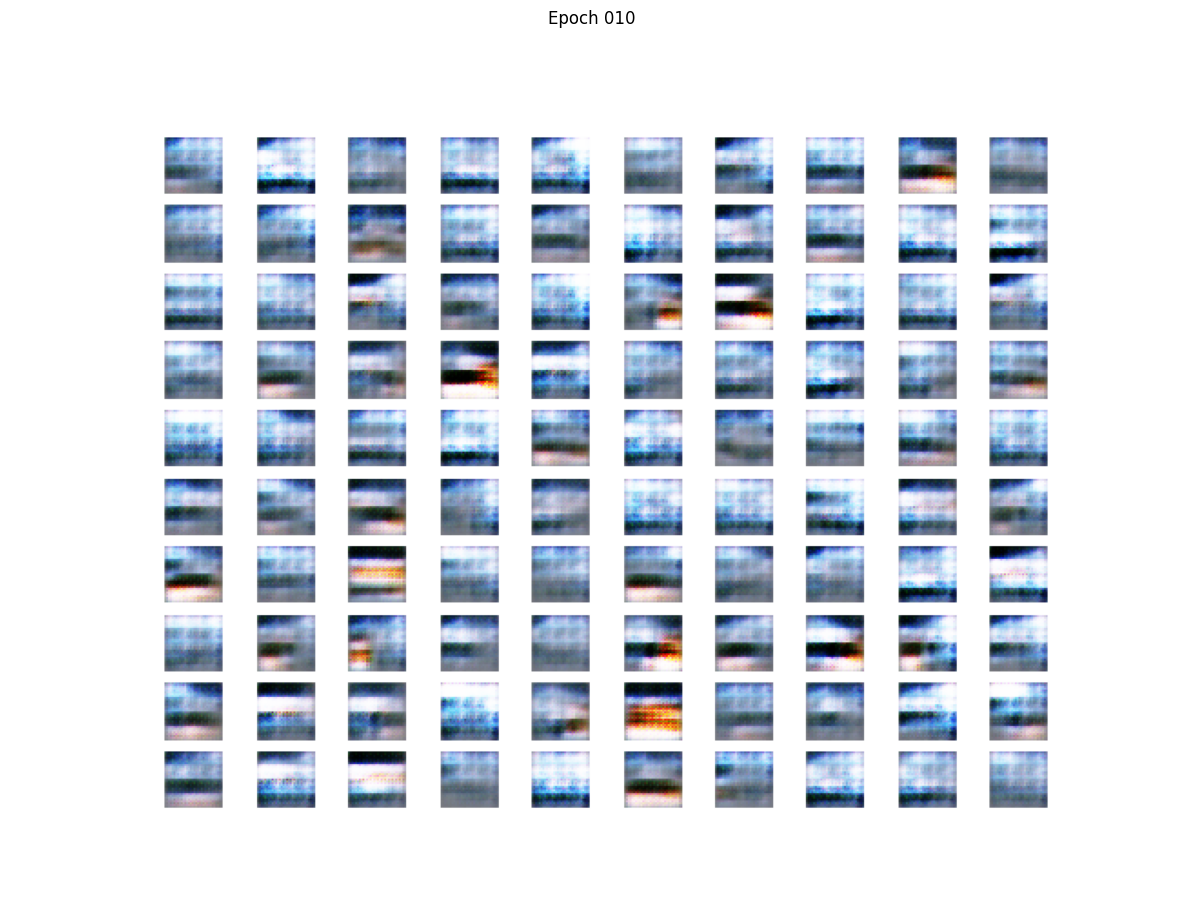

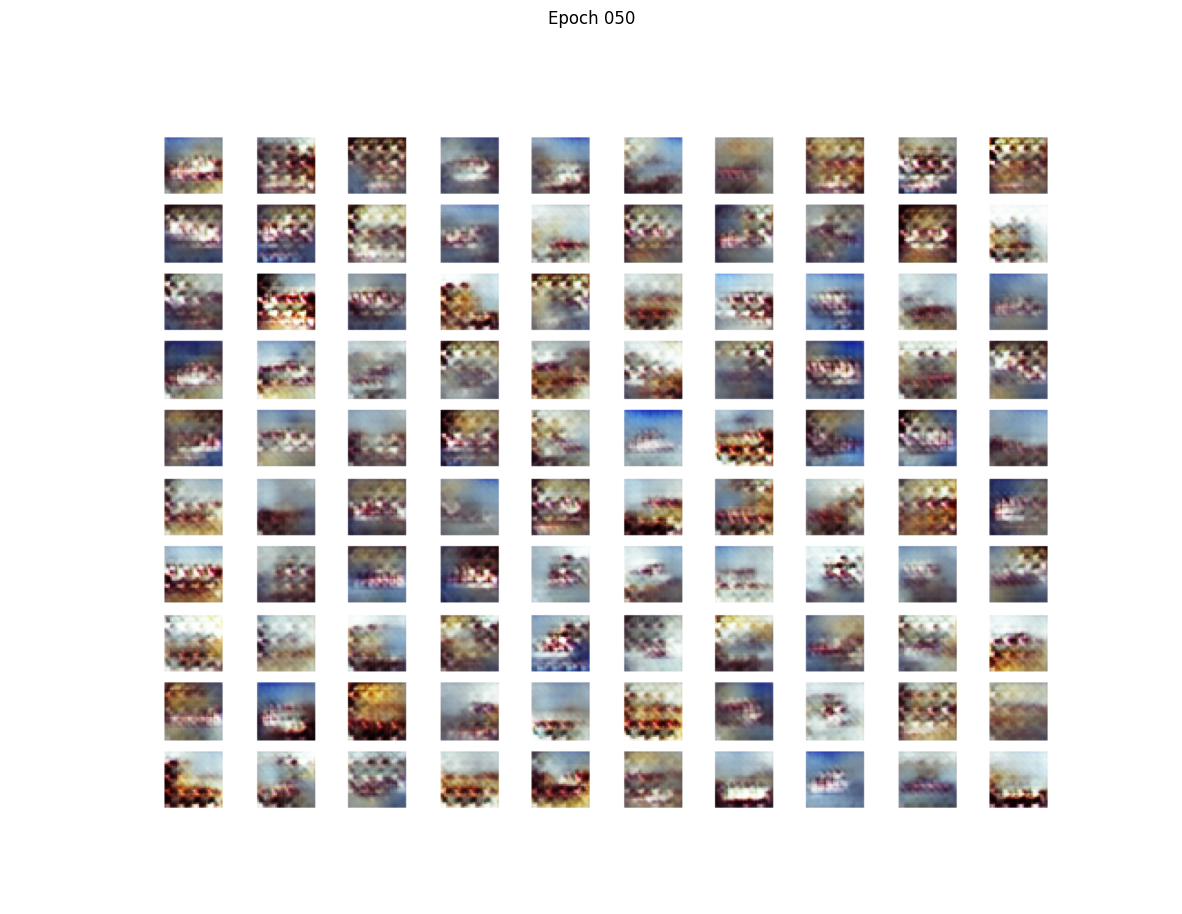

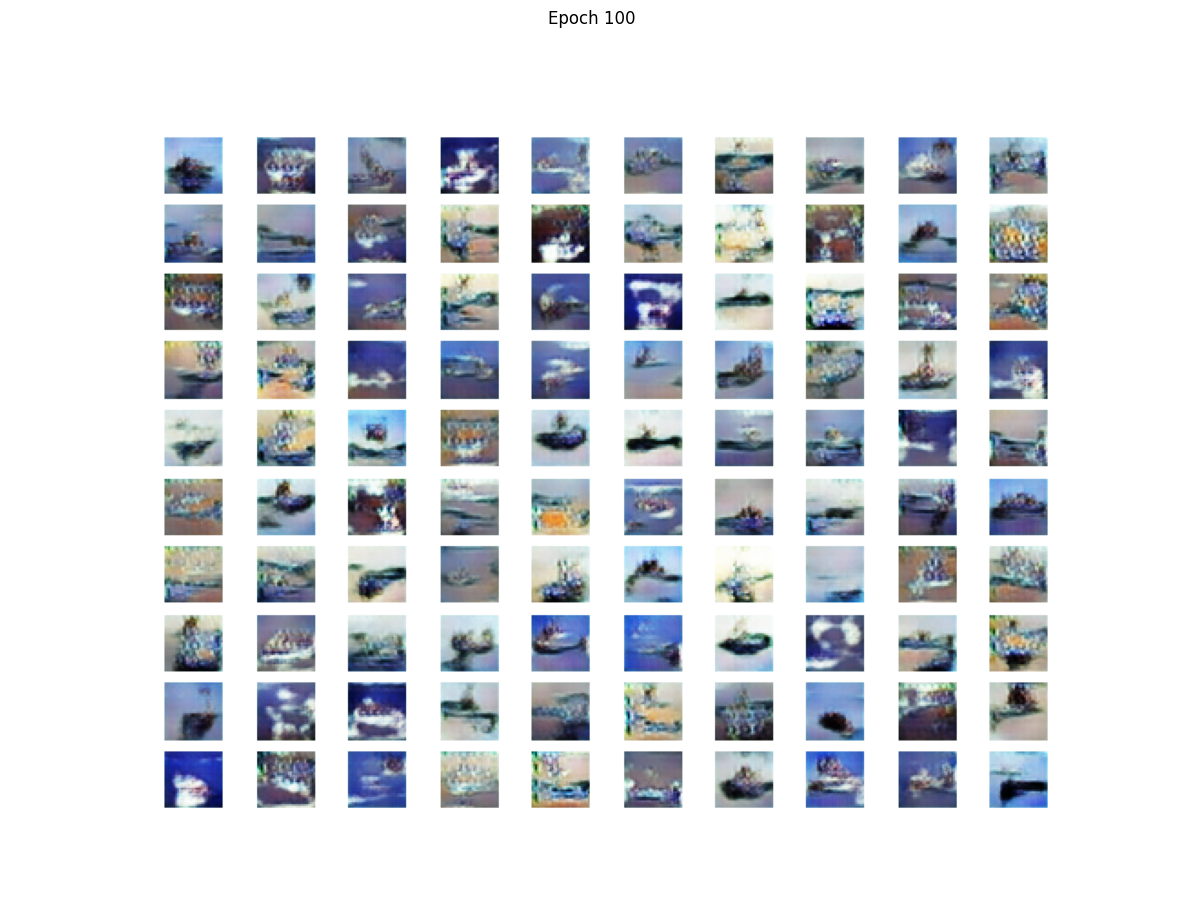

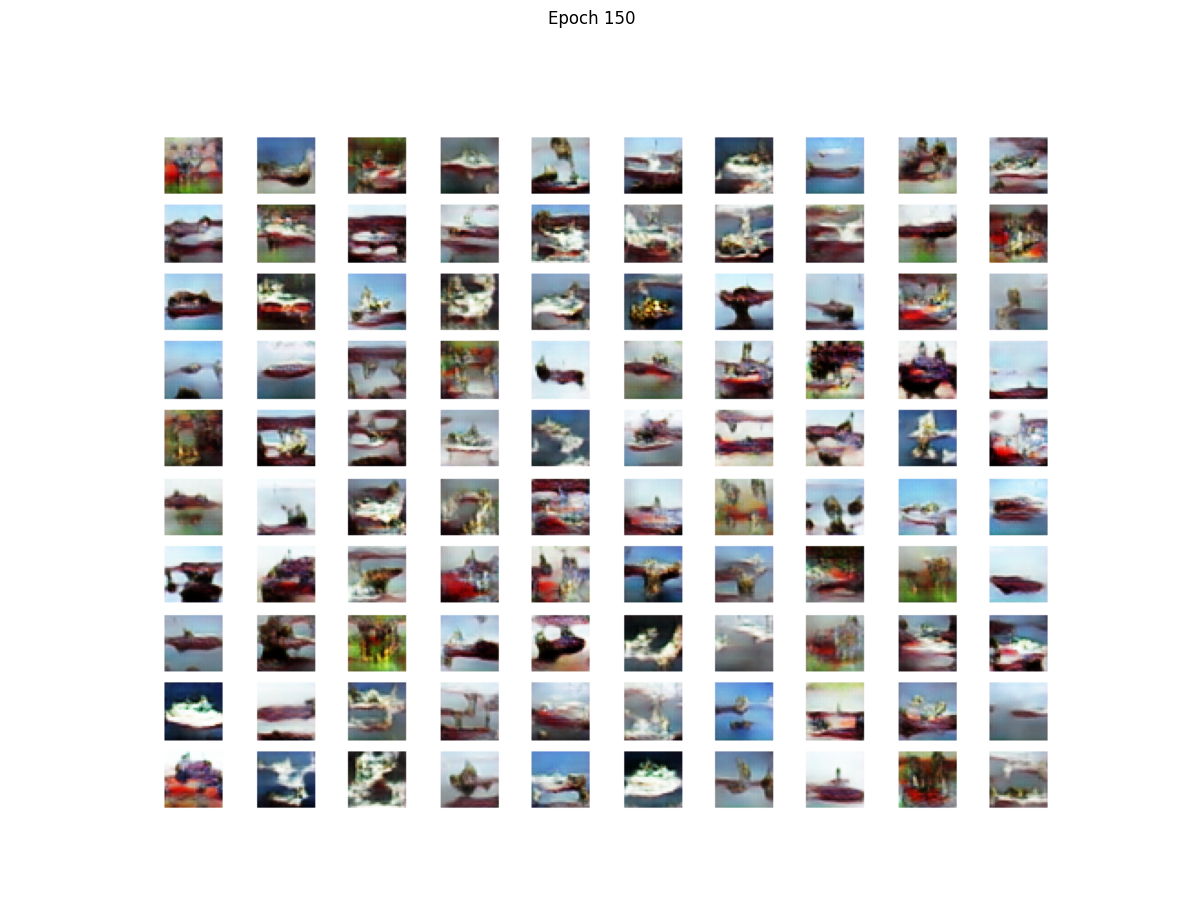

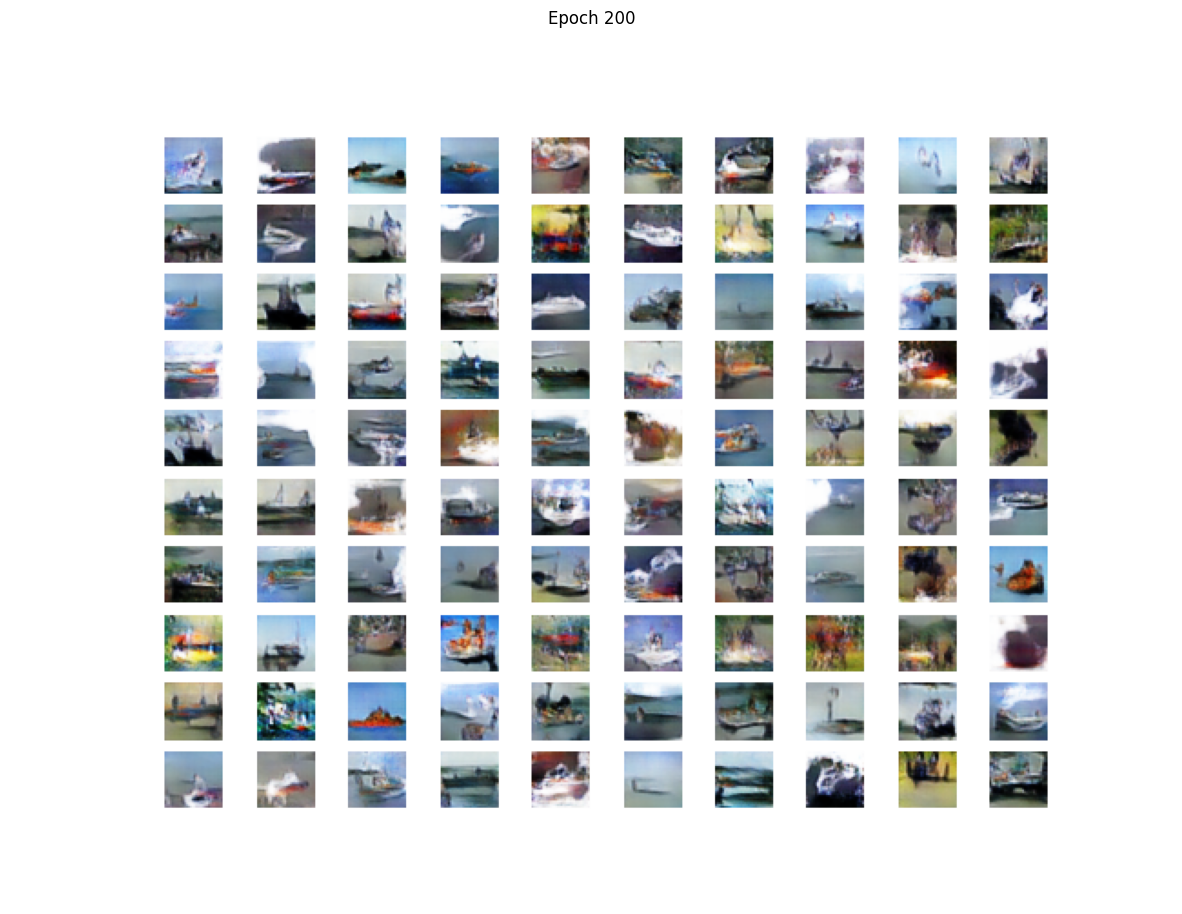

In [35]:
# Define file paths for images gererated during training
image_paths = [
    "/content/generated_1/Plot_epoch_010.png",
    "/content/generated_1/Plot_epoch_050.png",
    "/content/generated_1/Plot_epoch_100.png",
    "/content/generated_1/Plot_epoch_150.png",
    "/content/generated_1/Plot_epoch_200.png"
]

# Loop through each image path and plot it
for image_path in image_paths:
    epoch = image_path[-7:-4]
    # Load image
    img = Image.open(image_path)
    # Plot image
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 30ms/step


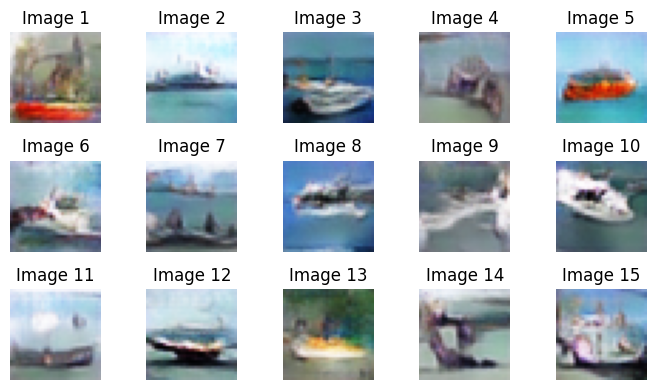

In [21]:
X_fake, _ = generate_fake_samples(g_model, 128, 15)
# Create a figure and axes for subplots of 15 generated of the final model
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(7, 4))

# Loop over the first 15 images
for i in range(15):
    # Calculate row and column indices
    row_index = i // 5
    col_index = i % 5

    # Display each image on a separate subplot
    x_fake = (X_fake[i] + 1) / 2.0
    axes[row_index, col_index].imshow(x_fake)
    axes[row_index, col_index].set_title(f"Image {i+1}")  # Optionally, set a title for each image
    axes[row_index, col_index].axis('off')

plt.tight_layout()
plt.show();


## 6) Save and load the models

In [36]:
# Save the Discriminator, Generator and GAN model
d_model.save('/content/generated_1/d_model.sav')
g_model.save('/content/generated_1/g_model.sav')
gan_model.save('/content/generated_1/gan_model.sav')

In [ ]:
# # Load the Generator from saved model
# g_model = keras.models.load_model("/content/generated_1/g_model.sav")

# # Generate 100 fake images by passing 128-dimensional random vectors through the Generator.
# X_fake, _ = generate_fake_samples(g_model, 128, 100)

In [37]:
# Compress output folders for downloading

!zip -r /content/generated_1/d_model.zip /content/generated_1/d_model.sav
!zip -r /content/generated_1/g_model.zip /content/generated_1/g_model.sav
!zip -r /content/generated_1/gan_model.zip /content/generated_1/gan_model.sav

  adding: content/generated_1/d_model.sav/ (stored 0%)
  adding: content/generated_1/d_model.sav/keras_metadata.pb (deflated 91%)
  adding: content/generated_1/d_model.sav/assets/ (stored 0%)
  adding: content/generated_1/d_model.sav/fingerprint.pb (stored 0%)
  adding: content/generated_1/d_model.sav/variables/ (stored 0%)
  adding: content/generated_1/d_model.sav/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/generated_1/d_model.sav/variables/variables.index (deflated 64%)
  adding: content/generated_1/d_model.sav/saved_model.pb (deflated 88%)
  adding: content/generated_1/g_model.sav/ (stored 0%)
  adding: content/generated_1/g_model.sav/keras_metadata.pb (deflated 92%)
  adding: content/generated_1/g_model.sav/assets/ (stored 0%)
  adding: content/generated_1/g_model.sav/fingerprint.pb (stored 0%)
  adding: content/generated_1/g_model.sav/variables/ (stored 0%)
  adding: content/generated_1/g_model.sav/variables/variables.data-00000-of-00001 (deflated 7%)
 

# B. Second-level requirement
Second-level requirement: train and generate images for ONE class of the dataset using the mechanism of ProGAN. In this requirement, you do not need to strictly follow the implementation in the ProGAN paper but feel free to construct a light version (a simple incremental network architecture) of it yourself. NOTE: it is fine to try and fail (i.e., you may not be able to generate good quality images), but at least you give it a try.

In [ ]:
# Your code goes here

## 1) Prepare samples

In [38]:
def load_real_samples():
    # merge the train_set and the test_set to the "real dataset"
    X = np.concatenate((train_set, test_set), axis=0)
    # Convert pixel values from unsigned int to float32 for normalization calculation.
    X = X.astype('float32')
    # Normalize from [0,255] to [-1,1] for tanh activation
    X = (X - 127.5) / 127.5
    # Return the set of normalized images
    return X

In [39]:
def create_dataset(res, BATCH_SIZE):
    data = load_real_samples() # image is loaded as numpy array
    # Function to resize and preprocess images
    def preprocess_image(image):
        image = tf.image.resize(image, [res, res])  # Resize image to (res, res)
        # Additional preprocessing steps if needed
        return image

    # Convert NumPy array to TensorFlow dataset and apply preprocessing
    train_dataset_tf = (
        tf.data.Dataset.from_tensor_slices(data)
        .map(preprocess_image)
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .batch(BATCH_SIZE, drop_remainder=True)  # Use the first batch size from BATCH_SIZE list
        .prefetch(tf.data.AUTOTUNE)
    )

    return train_dataset_tf

# Example usage:
# train_dataset = load_real_samples()
res = 4
BATCH_SIZE = [16, 16, 16, 16, 16, 16]
train_dataset = create_dataset(res, BATCH_SIZE[0])


In [40]:
# print out the shape of a data batch
for d in train_dataset.take(1):
  print(d.shape)

(16, 4, 4, 3)


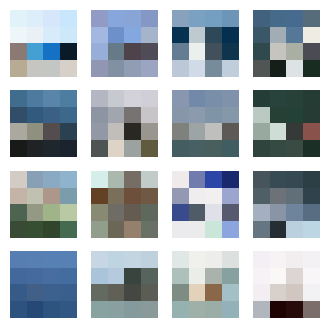

In [42]:
# Display some samples from the batch
plt.figure(figsize=(4, 4))
k = 0
n = 16

for i in range(n):
    ax = plt.subplot(4, 4, k + 1)
    # normalize the image from range [-1, 1] to [0, 1]
    plt.imshow((d[i] + 1) / 2)
    plt.axis("off")
    k += 1
plt.show()

## 2) Build ProGAN Model

In [46]:
class PixelNormalization(Layer):
    def __init__(self):
        super(PixelNormalization, self).__init__()

    def call(self, inputs):
        # Calculate the mean squared value of each input tensor along the last axis
        mean_square = tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True)

        # Compute the square root of the mean squared value with a small epsilon added
        l2 = tf.math.rsqrt(mean_square + 1.0e-8)

        # Normalize the input tensor element-wise
        normalized = inputs * l2

        return normalized

In [47]:
class WeightScaling(Layer):
    def __init__(self, shape, gain=np.sqrt(2)):
        super(WeightScaling, self).__init__()

        # Calculate the number of input features (fan-in)
        fan_in = tf.math.reduce_prod(shape)

        # Calculate the weight scaling factor
        self.wscale = gain * tf.math.rsqrt(fan_in)

    def call(self, inputs):
        # Cast inputs to float32
        inputs = tf.cast(inputs, tf.float32)

        # Scale the inputs by the weight scaling factor
        return inputs * self.wscale

In [48]:
class Bias(Layer):
    def __init__(self):
        super(Bias, self).__init__()

    def build(self, input_shape):
        # Initialize bias as zeros
        b_init = tf.zeros_initializer()

        # Create a trainable bias variable
        self.bias = tf.Variable(
            initial_value=b_init(shape=(input_shape[-1],), dtype='float32'),
            trainable=True
        )

    def call(self, inputs):
        # Add the bias to the inputs
        return inputs + self.bias

In [49]:
class WeightScalingDense(Layer):
    def __init__(self, n_units, gain, use_pixelnorm=False, activate=None):
        super(WeightScalingDense, self).__init__()
        self.n_units = n_units
        self.gain = gain
        self.use_pixelnorm = use_pixelnorm
        self.activate = activate

    def build(self, input_shape):
        # Initialize dense layer without bias
        self.dense = Dense(
            self.n_units,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),
            dtype='float32'
        )
        # Initialize bias layer
        self.bias = Bias()

    def call(self, inputs):
        in_filters = tf.shape(inputs)[-1]

        # Perform dense transformation
        x = self.dense(inputs)

        # Apply weight scaling
        x = WeightScaling(shape=(tf.cast(in_filters, dtype=tf.float32)), gain=self.gain)(x)

        # Add bias
        x = self.bias(x)

        # Apply activation function if specified
        if self.activate == 'LeakyReLU':
            x = LeakyReLU(0.2)(x)
        elif self.activate == 'tanh':
            x = Activation('tanh')(x)

        # Apply pixel normalization if specified
        if self.use_pixelnorm:
            x = PixelNormalization()(x)

        return x

In [50]:
class WeightScalingConv(Layer):
    def __init__(self, n_filters, kernel_size, gain, use_pixelnorm=False, activate=None, strides=(1, 1)):
        super(WeightScalingConv, self).__init__()
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.gain = gain
        self.use_pixelnorm = use_pixelnorm
        self.activate = activate
        self.strides = strides

    def build(self, input_shape):
        # Initialize convolutional layer without bias
        self.conv = Conv2D(
            self.n_filters,
            self.kernel_size,
            strides=self.strides,
            use_bias=False,
            padding="same",
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),
            dtype='float32'
        )
        # Initialize bias layer
        self.bias = Bias()

    def call(self, inputs):
        in_filters = tf.shape(inputs)[-1]

        # Perform convolutional transformation
        x = self.conv(inputs)

        # Apply weight scaling
        x = WeightScaling(
            shape=(
                tf.cast(self.kernel_size[0], dtype=tf.float32),
                tf.cast(self.kernel_size[1], dtype=tf.float32),
                tf.cast(in_filters, dtype=tf.float32)
            ),
            gain=self.gain
        )(x)

        # Add bias
        x = self.bias(x)

        # Apply activation function if specified
        if self.activate == 'LeakyReLU':
            x = LeakyReLU(0.2)(x)
        elif self.activate == 'tanh':
            x = Activation('tanh')(x)

        # Apply pixel normalization if specified
        if self.use_pixelnorm:
            x = PixelNormalization()(x)

        return x

In [51]:
class MinibatchStdev(Layer):
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate mean across the batch
        mean = tf.reduce_mean(inputs, axis=0, keepdims=True)

        # Calculate standard deviation across the batch
        stddev = tf.sqrt(tf.reduce_mean(tf.square(inputs - mean), axis=0, keepdims=True) + 1e-8)

        # Calculate the average standard deviation across all features
        average_stddev = tf.reduce_mean(stddev, keepdims=True)

        # Get the shape of the input tensor
        shape = tf.shape(inputs)

        # Tile the average standard deviation to match the shape of the input tensor
        minibatch_stddev = tf.tile(average_stddev, (shape[0], shape[1], shape[2], 1))

        # Concatenate the input tensor with the minibatch standard deviation
        combined = tf.concat([inputs, minibatch_stddev], axis=-1)

        return combined

In [52]:
class WeightedSum(Layer):
    def __init__(self):
        super(WeightedSum, self).__init__()

    def build(self, input_shape):
        # Initialize alpha as a trainable variable
        self.alpha = tf.Variable(0., dtype=tf.float32, trainable=False)

    def call(self, inputs):
        # Ensure only two inputs are provided
        assert len(inputs) == 2

        # Compute the weighted sum: (1 - alpha) * input1 + alpha * input2
        return (1.0 - self.alpha) * inputs[0] + self.alpha * inputs[1]

In [63]:
FILTERS = [256, 128, 128, 64]
class ProGAN(Model):
    def __init__(self,latent_dim,d_steps=1,gp_weight=10.0,drift_weight=0.001,):
        super(ProGAN, self).__init__()
        self.latent_dim = latent_dim
        self.d_steps = d_steps
        self.gp_weight = gp_weight
        self.drift_weight = drift_weight
        self.n_depth = 0
        self.discriminator = self.init_discriminator()
        self.discriminator_wt_fade = None
        self.generator = self.init_generator()
        self.generator_wt_fade = None

    def init_discriminator(self):
        img_input = Input(shape = (4,4,3))
        img_input = tf.cast(img_input, tf.float32)

        # "fromRGB" layer
        x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(1,1),gain=np.sqrt(2),activate='LeakyReLU')(img_input)

        x = MinibatchStdev()(x)

        x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(3,3),gain=np.sqrt(2),activate='LeakyReLU')(x)
        x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(4,4),gain=np.sqrt(2),activate='LeakyReLU', strides=(4,4))(x)

        x = Flatten()(x)

        x= WeightScalingDense(n_units=1,gain=1.)(x)

        d_model = Model(img_input, x, name='discriminator')

        return d_model

    def fade_in_discriminator(self):
        input_shape = list(self.discriminator.input.shape)

        input_shape = (input_shape[1]*2, input_shape[2]*2, input_shape[3])
        img_input = Input(shape = input_shape)
        img_input = tf.cast(img_input, tf.float32)

        # Left Branch - Older layer
        x1 = AveragePooling2D()(img_input) # halving the image resolution using average pooling
        x1 = self.discriminator.layers[1](x1) # "fromRGB" layer

        # Right Branch - New layer on the higher resolution
        x2=WeightScalingConv(FILTERS[self.n_depth],(1,1),np.sqrt(2),activate='LeakyReLU')(img_input)
        x2=WeightScalingConv(FILTERS[self.n_depth],(3,3),np.sqrt(2), activate='LeakyReLU')(x2)
        x2=WeightScalingConv(FILTERS[self.n_depth-1],(3,3),np.sqrt(2), activate='LeakyReLU')(x2)

        x2 = AveragePooling2D()(x2)

        # fading in the new layers smoothly
        x = WeightedSum()([x1, x2])

        # normal or straight-through discriminator = the stabilized version of the discriminator after fading-in
        for i in range(2, len(self.discriminator.layers)):
            x2 = self.discriminator.layers[i](x2)
        self.discriminator_stabilize = Model(img_input, x2, name='discriminator')

        # fade-in disciminator
        for i in range(2, len(self.discriminator.layers)):
            x = self.discriminator.layers[i](x)
        self.discriminator = Model(img_input, x, name='discriminator')
        self.discriminator.summary()

    def stabilize_discriminator(self):
        self.discriminator = self.discriminator_stabilize
        self.discriminator.summary()

    def init_generator(self):
        # create an input layer for noise
        noise = Input(shape=(self.latent_dim,))

        # apply pixel normalization to the input noise
        x = PixelNormalization()(noise)

        # apply weight scaling Dense layer followed by LeakyReLU and pixelnorm layer
        x=WeightScalingDense(n_units=4*4*FILTERS[0], gain=np.sqrt(2)/4, activate='LeakyReLU', use_pixelnorm=True)(x)

        # conv with activation and pixelnorm
        x = Reshape((4, 4, FILTERS[0]))(x)
        x=WeightScalingConv(FILTERS[0], kernel_size=(4,4), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)(x)
        x=WeightScalingConv(FILTERS[0], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)(x)

        # To-RGB layer
        x=WeightScalingConv(3, kernel_size=(1,1), gain=1., activate='tanh', use_pixelnorm=False)(x)

        # Create the generator model
        g_model = Model(noise, x, name='generator')
        g_model.summary()
        return g_model

    def fade_in_generator(self):
        # not include the to-RGB layer
        block_end = self.generator.layers[-2].output

        upsample = UpSampling2D((2,2))(block_end)

        # left Branh - Old layer
        x1 = self.generator.layers[-1](upsample) # to-RGB layer

        # right Branh - New layer on the higher resolution
        x2=WeightScalingConv(FILTERS[self.n_depth],(3,3),np.sqrt(2),
                           activate='LeakyReLU',use_pixelnorm=True)(upsample)
        x2=WeightScalingConv(FILTERS[self.n_depth],(3,3),np.sqrt(2),
                           activate='LeakyReLU',use_pixelnorm=True)(x2)
        x2=WeightScalingConv(3,(1,1),1.,activate='tanh',use_pixelnorm=False)(x2) # to-RGB layer

        # normal or straight-through generator = the stabilized version of the generator after fading-in
        self.generator_stabilize = Model(self.generator.input, x2, name='generator')

        # fade-in generator
        x = WeightedSum()([x1, x2])
        self.generator = Model(self.generator.input, x, name='generator')
        self.generator.summary()

    def stabilize_generator(self):
        self.generator = self.generator_stabilize
        self.generator.summary()

    def compile(self, d_optimizer, g_optimizer):
        super(ProGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def gradient_penalty(self,batch_size,real_images,fake_images):

        epsilon=tf.random.normal([batch_size,1,1,1],0.0,1.0)
        interpolation=epsilon*real_images+(1-epsilon)*fake_images

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolation)
            # 1. Get the discriminator output for this interpolated image
            prediction=self.discriminator(interpolation,training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads=gp_tape.gradient(prediction,interpolation)

        # 3. Calculate the norm of the gradients.
        l2_norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))

        return tf.reduce_mean((l2_norm-1)**2)

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_logits = self.discriminator(fake_images, training=True)
            real_logits = self.discriminator(real_images, training=True)

            d_cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

            gp = self.gradient_penalty(batch_size, real_images, fake_images)

            drift = tf.reduce_mean(tf.square(real_logits))
            d_loss = d_cost + self.gp_weight * gp + self.drift_weight * drift

        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = -tf.reduce_mean(gen_img_logits)

        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))
        return {'d_loss': d_loss, 'g_loss': g_loss}

In [62]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self,prefix,res,latent_dim=512,steps_per_epoch=1000,epochs=50,):
        self.latent_dim = latent_dim
        self.prefix=prefix
        self.steps_per_epoch=steps_per_epoch
        self.epochs=epochs
        self.res=res
        self.d_losses = []
        self.g_losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.n_epoch = epoch

    def on_epoch_end(self, epoch, logs=None):
        # track d_loss and g_loss for each epoch
        d_loss = logs.get('d_loss')
        g_loss = logs.get('g_loss')
        self.d_losses.append(d_loss)
        self.g_losses.append(g_loss)


    def on_batch_begin(self, batch, logs=None):
        alpha = ((self.n_epoch * self.steps_per_epoch) + batch)/float(self.steps_per_epoch * self.epochs - 1)
        for layer in self.model.generator.layers:
            if isinstance(layer, WeightedSum):
                layer.alpha.assign(alpha)
        for layer in self.model.discriminator.layers:
            if isinstance(layer, WeightedSum):
                layer.alpha.assign(alpha)

    def on_train_end(self, logs=None):
        # save the loss dataframe
        loss_df = pd.DataFrame({'d_loss': self.d_losses, 'g_loss': self.g_losses}, index=range(1, len(self.d_losses) + 1))
        loss_df.to_csv(f'/content/generated_2/summary_{self.res}x{self.res}_{self.prefix}.csv')

        # save generated images by model
        n = 6
        k = 0
        out = self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
            for j in range(n):
                ax = plt.subplot(n, n, k + 1)
                plt.imshow((out[k] + 1) / 2,)
                plt.axis('off')
                k += 1
        plt.savefig("generated_2/gen_images_{}x{}_{}.png".format(self.res, self.res, self.prefix))
        plt.close()


## 3) Train model

In [58]:
!mkdir generated_2

In [64]:
STEPS_PER_EPOCH=1000
EPOCHS=[50, 50, 50, 100]
NOISE_DIM=512

In [65]:
# Create training dataset
train_dataset = create_dataset(4, BATCH_SIZE[0])

# Define optimizer for generator and discriminator
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

# Initialize ProGAN model
pgan = ProGAN(
    latent_dim=NOISE_DIM,
    d_steps=1,
)

# Compile the model with optimizers
pgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
)

# Define callback for displaying images during training
cbk = ShowImage('initial', 4, latent_dim=512, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS[0])

# Initial Phase Training (Resolution 4x4)
pgan.fit(train_dataset.take(STEPS_PER_EPOCH), epochs=EPOCHS[0], callbacks=[cbk])

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512)]             0         
                                                                 
 pixel_normalization_1 (Pix  (None, 512)               0         
 elNormalization)                                                
                                                                 
 weight_scaling_dense_3 (We  (None, 4096)              2101248   
 ightScalingDense)                                               
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 weight_scaling_conv_9 (Wei  (None, 4, 4, 256)         1048832   
 ghtScalingConv)                                                 
                                                         

375/375 [==============================] - 9s 14ms/step - d_loss: -0.7614 - g_loss: 1.1548
Epoch 2/50
375/375 [==============================] - 5s 15ms/step - d_loss: -0.3007 - g_loss: 0.6239
Epoch 3/50
375/375 [==============================] - 5s 14ms/step - d_loss: -0.0817 - g_loss: 0.2729
Epoch 4/50
375/375 [==============================] - 5s 14ms/step - d_loss: -0.0670 - g_loss: 0.2188
Epoch 5/50
375/375 [==============================] - 5s 14ms/step - d_loss: -0.0272 - g_loss: 0.1495
Epoch 6/50
375/375 [==============================] - 5s 14ms/step - d_loss: -0.0744 - g_loss: 0.2290
Epoch 7/50
375/375 [==============================] - 6s 15ms/step - d_loss: -0.0951 - g_loss: 0.3844
Epoch 8/50
375/375 [==============================] - 5s 14ms/step - d_loss: -0.1298 - g_loss: 0.4033
Epoch 9/50
375/375 [==============================] - 6s 15ms/step - d_loss: -0.1440 - g_loss: 0.4607
Epoch 10/50
375/375 [==============================] - 5s 14ms/step - d_loss: -0.1727 - g_los

In [66]:
# Training with increasing Resolution (8x8, 16x16, 32x32)
for n_depth in range(1, 4):

    # Fading Phase Training
    pgan.n_depth = n_depth
    train_dataset=create_dataset(4*(2**n_depth),BATCH_SIZE[n_depth])

    cbk=ShowImage('fading',4*(2**n_depth),latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS[n_depth])
    pgan.fade_in_generator()
    pgan.fade_in_discriminator()

    pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
    )

    pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs = EPOCHS[n_depth], callbacks=[cbk])

    # Stabilizing Phase Training

    cbk=ShowImage('stabilize',4*(2**n_depth),latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS[n_depth])
    pgan.stabilize_generator()
    pgan.stabilize_discriminator()

    pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
    )
    pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs=EPOCHS[n_depth], callbacks=[cbk])

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 pixel_normalization_1 (Pix  (None, 512)                  0         ['input_6[0][0]']             
 elNormalization)                                                                                 
                                                                                                  
 weight_scaling_dense_3 (We  (None, 4096)                 2101248   ['pixel_normalization_1[0][0]'
 ightScalingDense)                                                  ]                             
                                                                                          

375/375 [==============================] - 11s 21ms/step - d_loss: -0.1719 - g_loss: 0.2696
Epoch 2/50
375/375 [==============================] - 8s 20ms/step - d_loss: -0.1562 - g_loss: 0.3993
Epoch 3/50
375/375 [==============================] - 8s 21ms/step - d_loss: -0.1771 - g_loss: 0.2866
Epoch 4/50
375/375 [==============================] - 8s 21ms/step - d_loss: -0.1863 - g_loss: 0.2457
Epoch 5/50
375/375 [==============================] - 8s 21ms/step - d_loss: -0.1711 - g_loss: 0.3144
Epoch 6/50
375/375 [==============================] - 8s 21ms/step - d_loss: -0.1829 - g_loss: 0.3094
Epoch 7/50
375/375 [==============================] - 8s 21ms/step - d_loss: -0.1817 - g_loss: 0.3669
Epoch 8/50
375/375 [==============================] - 8s 21ms/step - d_loss: -0.1808 - g_loss: 0.3377
Epoch 9/50
375/375 [==============================] - 8s 21ms/step - d_loss: -0.1772 - g_loss: 0.4198
Epoch 10/50
375/375 [==============================] - 8s 21ms/step - d_loss: -0.1768 - g_lo

375/375 [==============================] - 15s 31ms/step - d_loss: -0.2576 - g_loss: 0.6141
Epoch 2/50
375/375 [==============================] - 12s 32ms/step - d_loss: -0.2645 - g_loss: 0.5376
Epoch 3/50
375/375 [==============================] - 12s 32ms/step - d_loss: -0.2775 - g_loss: 0.5726
Epoch 4/50
375/375 [==============================] - 12s 31ms/step - d_loss: -0.2779 - g_loss: 0.4969
Epoch 5/50
375/375 [==============================] - 12s 31ms/step - d_loss: -0.2882 - g_loss: 0.7207
Epoch 6/50
375/375 [==============================] - 12s 31ms/step - d_loss: -0.2659 - g_loss: 0.3596
Epoch 7/50
375/375 [==============================] - 12s 31ms/step - d_loss: -0.2868 - g_loss: 0.4560
Epoch 8/50
375/375 [==============================] - 12s 31ms/step - d_loss: -0.3159 - g_loss: 0.7050
Epoch 9/50
375/375 [==============================] - 12s 32ms/step - d_loss: -0.3159 - g_loss: 0.6600
Epoch 10/50
375/375 [==============================] - 12s 31ms/step - d_loss: -0.28

375/375 [==============================] - 24s 52ms/step - d_loss: -0.6771 - g_loss: 0.9032
Epoch 2/100
375/375 [==============================] - 20s 52ms/step - d_loss: -0.7034 - g_loss: 1.1334
Epoch 3/100
375/375 [==============================] - 19s 52ms/step - d_loss: -0.6682 - g_loss: 0.7903
Epoch 4/100
375/375 [==============================] - 19s 52ms/step - d_loss: -0.6726 - g_loss: 1.1807
Epoch 5/100
375/375 [==============================] - 19s 52ms/step - d_loss: -0.6725 - g_loss: 0.7600
Epoch 6/100
375/375 [==============================] - 19s 52ms/step - d_loss: -0.6987 - g_loss: 1.0735
Epoch 7/100
375/375 [==============================] - 20s 52ms/step - d_loss: -0.7023 - g_loss: 0.9028
Epoch 8/100
375/375 [==============================] - 19s 52ms/step - d_loss: -0.6866 - g_loss: 0.9368
Epoch 9/100
375/375 [==============================] - 19s 52ms/step - d_loss: -0.6964 - g_loss: 1.0659
Epoch 10/100
375/375 [==============================] - 20s 52ms/step - d_lo

## 4) Visualize the model behaviors during the training

In [67]:
# Define the directory path containing the CSV files
directory_path = '/content/generated_2/'

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# Read each CSV file and store it in a dictionary
dfs = {}
for file in csv_files:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(os.path.join(directory_path, file), index_col=0)
    # Store the DataFrame in the dictionary with the file name as the key
    dfs[file] = df
dfs.keys()

dict_keys(['summary_4x4_initial.csv', 'summary_16x16_stabilize.csv', 'summary_16x16_fading.csv', 'summary_8x8_fading.csv', 'summary_8x8_stabilize.csv', 'summary_32x32_fading.csv', 'summary_32x32_stabilize.csv'])

In [71]:
def find_resolution_and_status(table_name):
    # Find the index range for resolution substring
    r_from_i = table_name.find('_') + 1
    r_to_i = table_name[r_from_i:].find('_') + r_from_i

    # Find the index range for status substring
    s_from_i = r_to_i + 1
    s_to_i = table_name[s_from_i:].find('.') + s_from_i

    # Extract resolution and status from table name using index ranges
    return table_name[r_from_i:r_to_i], table_name[s_from_i:s_to_i]

# Define ordered keys
ordered_keys = ['summary_4x4_initial.csv',
                'summary_8x8_fading.csv', 'summary_8x8_stabilize.csv',
                'summary_16x16_fading.csv', 'summary_16x16_stabilize.csv',
                'summary_32x32_fading.csv', 'summary_32x32_stabilize.csv'
                ]

# Iterate through ordered keys and update DataFrames with resolution and status columns
for k in ordered_keys:
    dfs[k]['resolution'] = find_resolution_and_status(k)[0]
    dfs[k]['status'] = find_resolution_and_status(k)[1]

# Concatenate DataFrames to create a merged DataFrame
dfs_ordered = [dfs[key] for key in ordered_keys]
merged_df = pd.concat(dfs_ordered, axis=0, ignore_index=True)

In [69]:
merged_df

d_loss    g_loss resolution     status
0   -0.672379  0.374161        4x4    initial
1    0.258001 -0.318293        4x4    initial
2   -0.176860  0.201485        4x4    initial
3    0.086741  0.129707        4x4    initial
4    0.013804  0.075163        4x4    initial
..        ...       ...        ...        ...
445 -1.264969 -1.037756      32x32  stabilize
446 -0.593568  4.172935      32x32  stabilize
447 -0.436449  0.096294      32x32  stabilize
448 -0.813568  0.691280      32x32  stabilize
449 -1.886411  5.524268      32x32  stabilize

[450 rows x 4 columns]

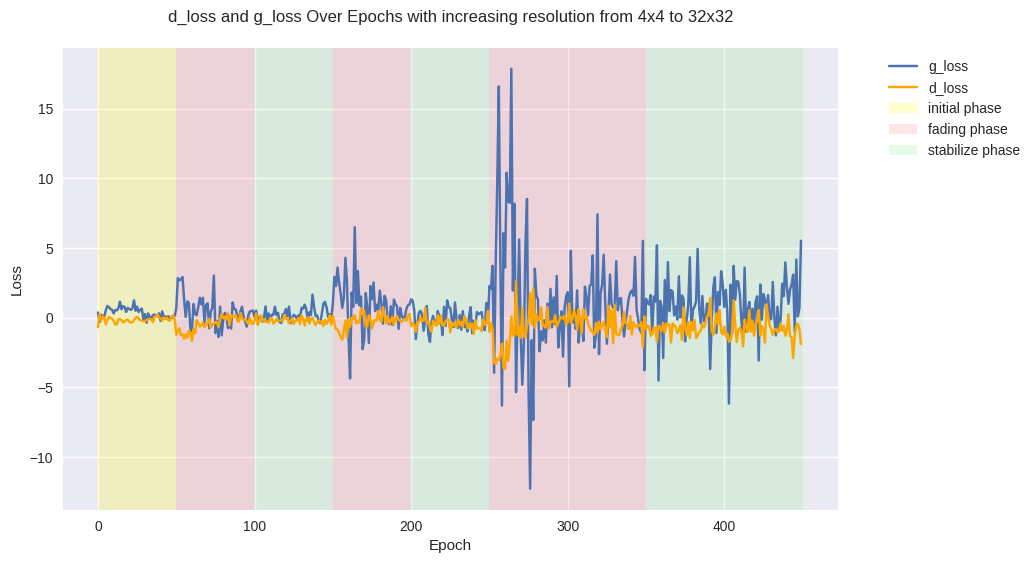

In [70]:
plt.style.use('seaborn-v0_8')
# Plot d_loss and g_loss
plt.figure(figsize=(10, 6))

plt.plot(merged_df.index, merged_df['g_loss'], label='g_loss')
plt.plot(merged_df.index, merged_df['d_loss'], label='d_loss', c='orange')

# Customize background color
ax = plt.gca()

# Define gradient for x-axis range from 50 to 100
ax.axvspan(0, 50, facecolor='yellow', alpha=0.2, label='initial phase')
ax.axvspan(50, 100, facecolor='red', alpha=0.1, label='fading phase')
ax.axvspan(150, 200, facecolor='red', alpha=0.1)
ax.axvspan(250, 350, facecolor='red', alpha=0.1)
ax.axvspan(100, 150, facecolor='lightgreen', alpha=0.2, label='stabilize phase')
ax.axvspan(200, 250, facecolor='lightgreen', alpha=0.2)
ax.axvspan(350, 450, facecolor='lightgreen', alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('d_loss and g_loss Over Epochs with increasing resolution from 4x4 to 32x32\n')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show();


## 5) Visualize the generated images.

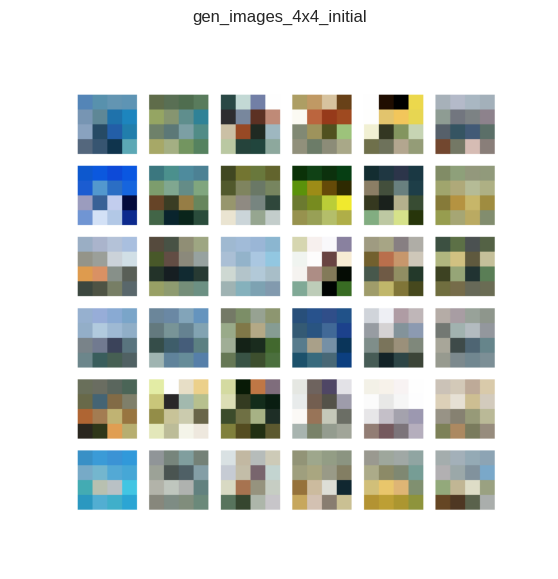

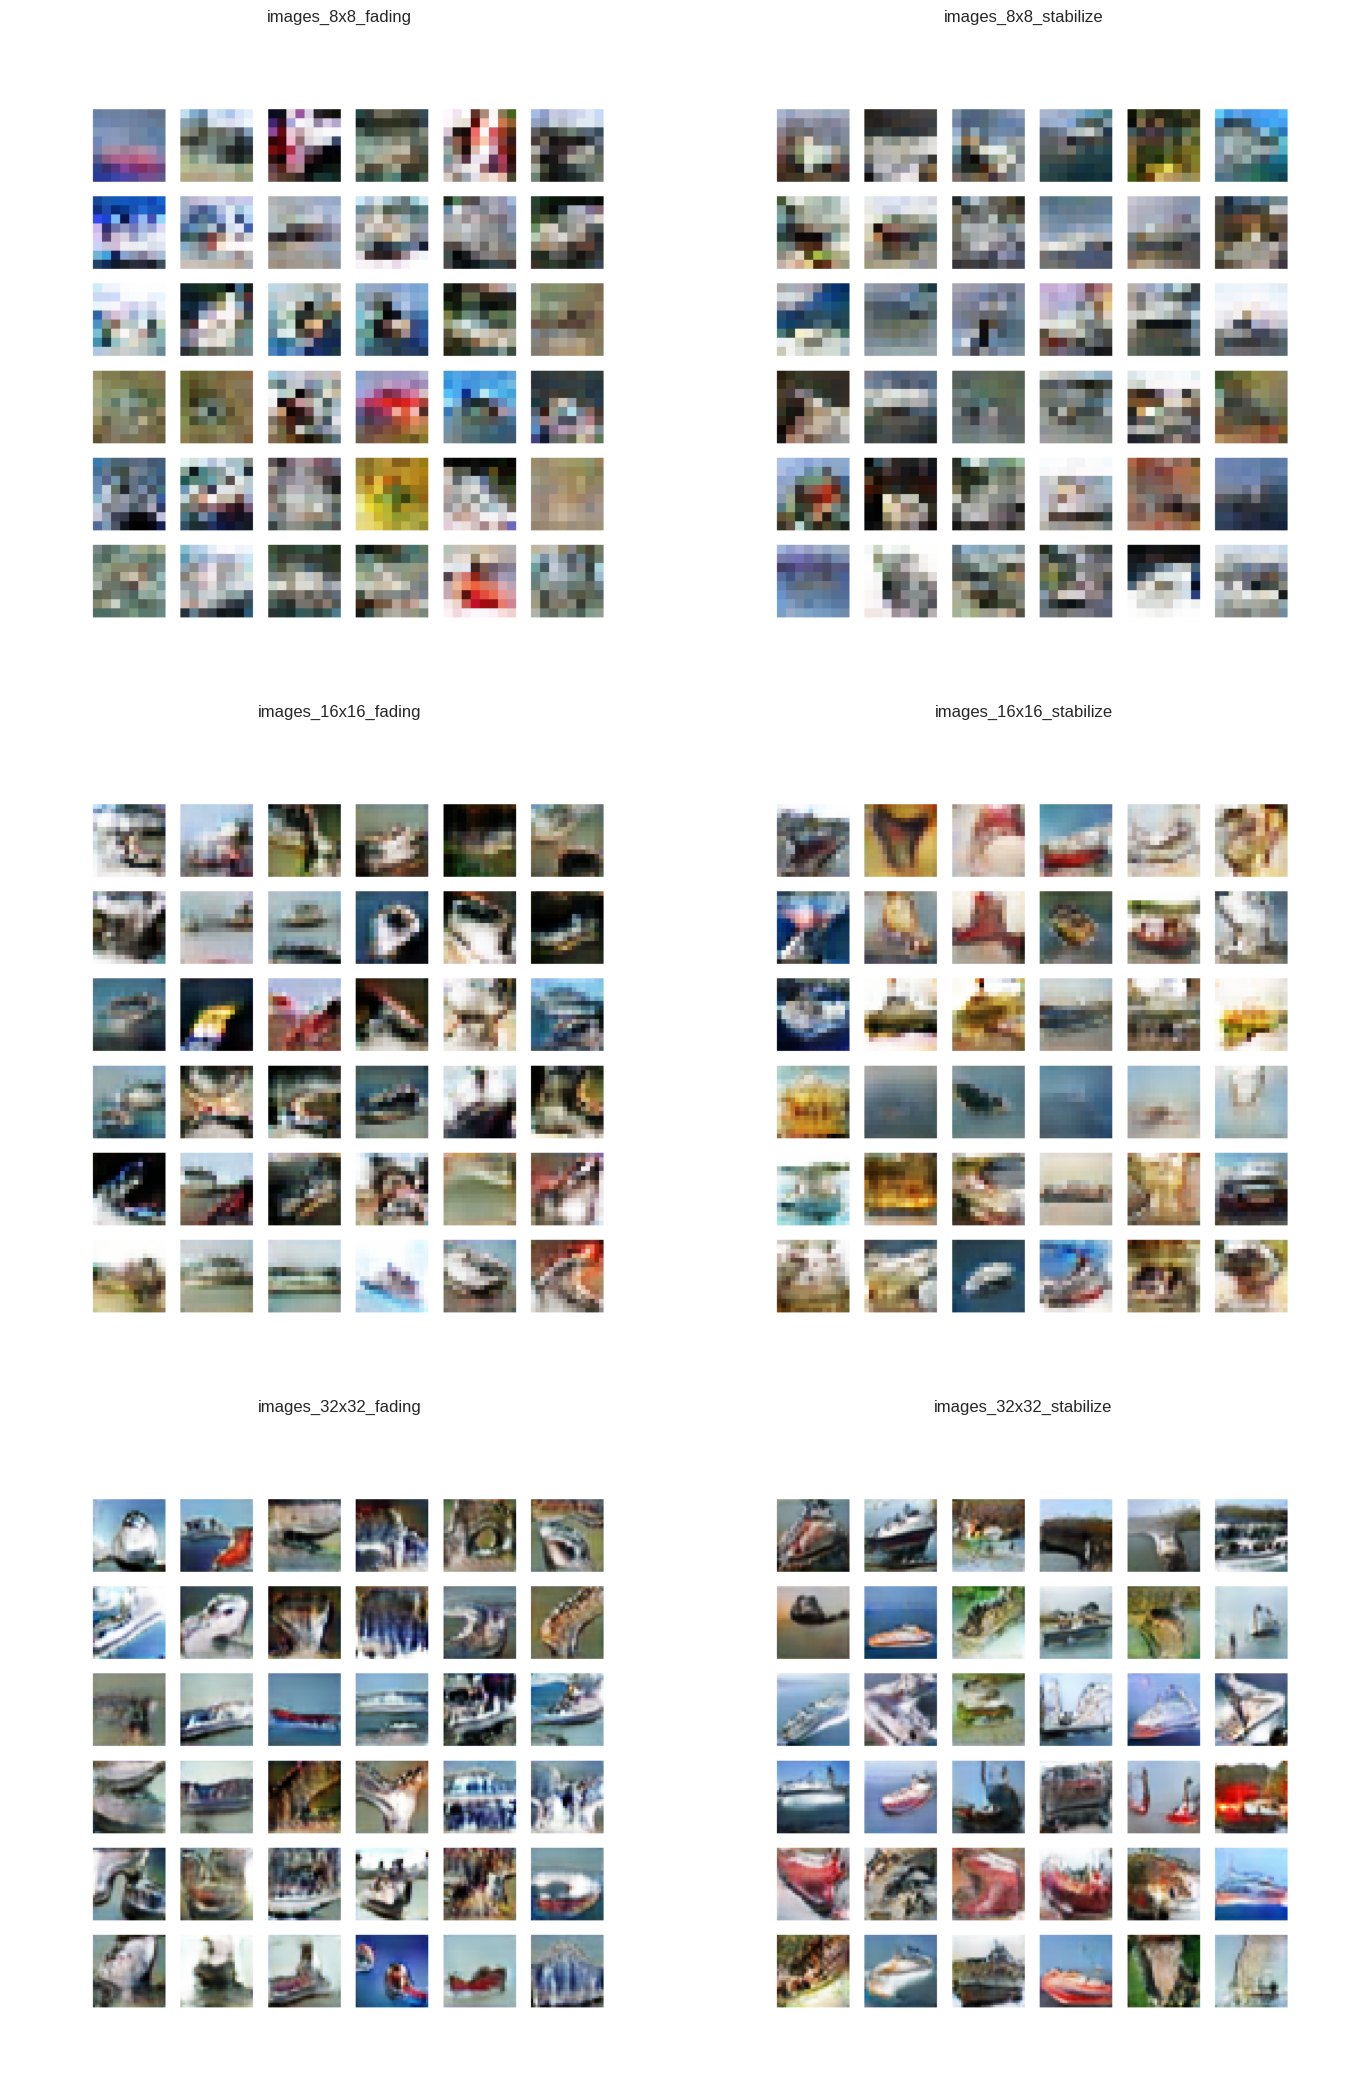

In [93]:
# Define file paths for images
image_paths = [
    "/content/generated_2/gen_images_4x4_initial.png",
    "/content/generated_2/gen_images_8x8_fading.png",
    "/content/generated_2/gen_images_8x8_stabilize.png",
    "/content/generated_2/gen_images_16x16_fading.png",
    "/content/generated_2/gen_images_16x16_stabilize.png",
    "/content/generated_2/gen_images_32x32_fading.png",
    "/content/generated_2/gen_images_32x32_stabilize.png"
]

# Plot the 4x4 image
plt.figure(figsize=(7, 7))
img_4x4 = Image.open(image_paths[0])
plt.imshow(img_4x4)
plt.axis('off')
plt.title(image_paths[0].split('/')[-1].split('.')[0])  # Extract filename as title
plt.show();

# Plot the rest of the images
plt.figure(figsize=(14, 21))
for i, image_path in enumerate(image_paths[1:]):

    plt.subplot(3, 2, i+1)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_path.split('gen_')[-1].split('.')[0])  # Extract filename as title
plt.tight_layout()
plt.show();

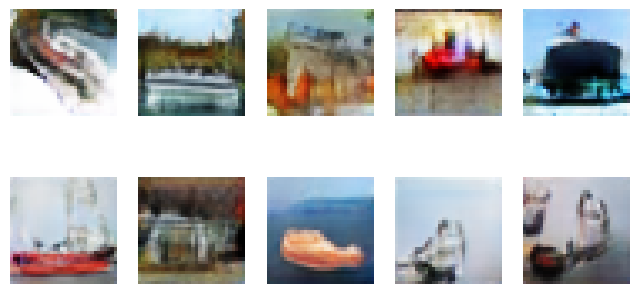

In [97]:
latent_dim = 512
num_images_to_generate = 100

# Generate random noise samples
random_latent_vectors = tf.random.normal(shape=(num_images_to_generate, latent_dim))

# Generate images using the generator
generated_images = pgan.generator(random_latent_vectors)

# visualize the generated imaged
plt.figure(figsize = (8,4))
k=0
n = 10
for i in range(n):
    ax = plt.subplot(2,5, k+1)
    plt.imshow((generated_images[i]+1)/2)
    plt.axis("off")
    k+=1

## 6) Save the model's weight

In [98]:
pgan.generator.save_weights('/content/generated_2/pggan_generator_32.h5')
pgan.discriminator.save_weights('/content/generated_2/pggan_discriminator_32.h5')

In [99]:
!zip -r /content/generated_2/result_proGANv4.zip /content/generated_2

  adding: content/generated_2/ (stored 0%)
  adding: content/generated_2/gen_images_8x8_stabilize.png (deflated 53%)
  adding: content/generated_2/gen_images_16x16_fading.png (deflated 28%)
  adding: content/generated_2/summary_4x4_initial.csv (deflated 50%)
  adding: content/generated_2/gen_images_32x32_fading.png (deflated 12%)
  adding: content/generated_2/summary_16x16_stabilize.csv (deflated 50%)
  adding: content/generated_2/summary_16x16_fading.csv (deflated 49%)
  adding: content/generated_2/gen_images_8x8_fading.png (deflated 53%)
  adding: content/generated_2/summary_8x8_fading.csv (deflated 49%)
  adding: content/generated_2/summary_8x8_stabilize.csv (deflated 50%)
  adding: content/generated_2/summary_32x32_fading.csv (deflated 48%)
  adding: content/generated_2/pggan_generator_32.h5 (deflated 8%)
  adding: content/generated_2/gen_images_16x16_stabilize.png (deflated 28%)
  adding: content/generated_2/summary_32x32_stabilize.csv (deflated 49%)
  adding: content/generated_2/

In [ ]:
from google.colab import files
files.download("/content/generated_2/result_proGANv4.zip")

## 7) Load the model and run prediction

In [102]:
# rerun the fit method to get the structure for the model
pgan = ProGAN(latent_dim=NOISE_DIM, d_steps=1)
# Compile the model with optimizers
pgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
)

# Define callback for displaying images during training
cbk = ShowImage('initial', 4, latent_dim=512, steps_per_epoch=STEPS_PER_EPOCH, epochs=0)
pgan.fit(train_dataset.take(STEPS_PER_EPOCH), epochs=0, callbacks=[cbk])

for n_depth in range(1, 4):

    # Fading Phase Training
    pgan.n_depth = n_depth
    train_dataset=create_dataset(4*(2**n_depth),BATCH_SIZE[n_depth])

    cbk=ShowImage('fading',4*(2**n_depth),latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=0)
    pgan.fade_in_generator()
    pgan.fade_in_discriminator()

    pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
    )

    pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs = 0, callbacks=[cbk])

    # Stabilizing Phase Training

    cbk=ShowImage('stabilize',4*(2**n_depth),latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=0)
    pgan.stabilize_generator()
    pgan.stabilize_discriminator()

    pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
    )
    pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs=0, callbacks=[cbk])

# get the generator and discriminator from the model
generator = pgan.generator
discriminator = pgan.discriminator
# load the weight for the model
generator.load_weights('/content/generated_2/pggan_generator_32.h5')
discriminator.load_weights('/content/generated_2/pggan_discriminator_32.h5')


# You can now use the loaded models for prediction
latent_dim = 512  # Assuming the dimensionality of your latent space is 512
num_images_to_generate = 10

# Generate random noise samples
random_latent_vectors = tf.random.normal(shape=(num_images_to_generate, latent_dim))

# Generate images using the generator
generated_images = generator(random_latent_vectors)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 512)]             0         
                                                                 
 pixel_normalization_103 (P  (None, 512)               0         
 ixelNormalization)                                              
                                                                 
 weight_scaling_dense_9 (We  (None, 4096)              2101248   
 ightScalingDense)                                               
                                                                 
 reshape_6 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 weight_scaling_conv_63 (We  (None, 4, 4, 256)         1048832   
 ightScalingConv)                                                
                                                         

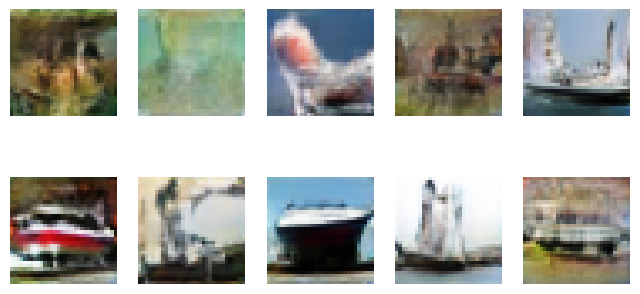

In [103]:
# visualize the generated imaged
plt.figure(figsize = (8,4))
k=0
n = 10
for i in range(n):
    ax = plt.subplot(2,5, k+1)
    plt.imshow((generated_images[i]+1)/2)
    plt.axis("off")
    k+=1